# makemore part 3: Activations & Gradients, BatchNorm

## What is makemore?

Makemore "makes more" of things that you give it. Example uses `names.txt` and makemore learns to make names

Under the hood, makemore is a character-level language model: it treats each line as sequences of individual characters. Model sequence of characters and try to predict next characters in a sequence.

This class will look at 
1. Bigram (one character simply predicts a next one with a lookup table of counts)
2. ~~Bag of Words~~
   1. The table explodes! We'll skip
3. **Multilayer Perceptron**
4. Recurrent Neural Network
5. GRU
6. Transformers

Will build a transformer equivalent to GPT-2, at the level of characters

## Agenda
Characters
Words
Images

---

## External Resources

### Lesson

[Building makemore part 3 (Activations, Gradients, BatchNorm: behind the scenes for MLP) (youtube)](https://www.youtube.com/watch?v=P6sfmUTpUmc)

___

## Import necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

---

In [2]:
# read in all the words
names_data = '../../data/raw/names.txt'

words = open(names_data, 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i  in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset but via a function instead
block_size = 3 # context length: how many characters do we take to predict the next one?
    
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0 /  200000: 27.8817
  10000 /  200000: 2.7884
  20000 /  200000: 2.5921
  30000 /  200000: 2.8912
  40000 /  200000: 2.0590
  50000 /  200000: 2.5476
  60000 /  200000: 2.4168
  70000 /  200000: 2.1279
  80000 /  200000: 2.3745
  90000 /  200000: 2.2869
 100000 /  200000: 2.0507
 110000 /  200000: 2.3585
 120000 /  200000: 1.8682
 130000 /  200000: 2.4067
 140000 /  200000: 2.1842
 150000 /  200000: 2.2043
 160000 /  200000: 2.1153
 170000 /  200000: 1.7554
 180000 /  200000: 2.0232
 190000 /  200000: 1.9291


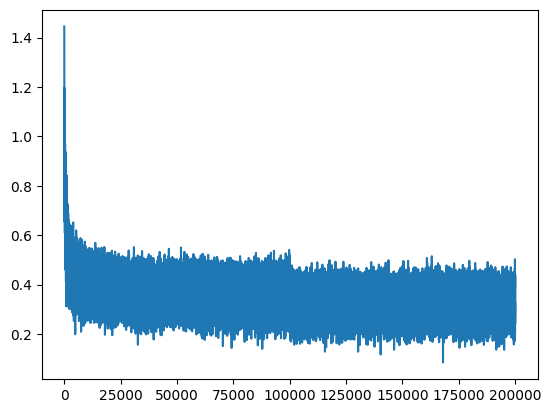

In [8]:
plt.plot(lossi);

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1280276775360107
val 2.1642096042633057


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) #decode and print the generated word

mora.
mayah.
see.
mel.
ryllo.
emmrclendrami.
adered.
elin.
shyloe.
leigh.
estanar.
kayziquetra.
noshubergahimiest.
jairenellonnie.
casu.
zen.
dariyah.
faeh.
yuma.
myston.


Scrutinizing the model:

1. Something is off with the initialization. Looking at the initial loss, it's way up at 24 and quickly drops to ~2. However, in our case, we already have a rough base case for loss that we should be better than. We can guess uniform distribution for all characters, so the probability should be 1/27, which we can take the log off and then the negative

In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

So at initialization, our model is very confident about some values but wrong. If we look up, we can see that we're initializing a lot of values to be random numbers, but it would be better if the logits were much closer to 0

In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


While it's ok to make a bias vector 0, you should not make a weight matrix 0! 

In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break
    

      0 /  200000: 3.3221


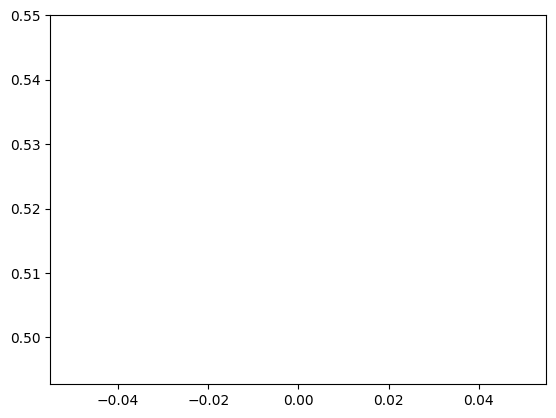

In [14]:
plt.plot(lossi);

Before, we were wasting epochs squashing down weights and getting out of the hockey stick loss. Hockey stick loss is a sign that we didn't start in a good spot

In [15]:
split_loss('train')
split_loss('val')

train 3.1878931522369385
val 3.187795877456665


Other problem has to do with the activation layer. In the video, he shows that many of them are +-1

In [16]:
h.shape

torch.Size([32, 200])

In [17]:
h.view(-1)

tensor([ 0.8100, -0.8997, -0.9993,  ..., -0.1266,  1.0000,  1.0000],
       grad_fn=<ViewBackward0>)

In [18]:
h.view(-1).tolist()

[0.8100222945213318,
 -0.8996702432632446,
 -0.999309241771698,
 0.9980825185775757,
 -0.6508485078811646,
 -0.6897538304328918,
 -0.9619210362434387,
 -0.9999876022338867,
 -0.3420684039592743,
 0.999920666217804,
 0.9999915957450867,
 -0.9980642199516296,
 0.9876819252967834,
 0.8998497128486633,
 0.8862370252609253,
 0.7360541820526123,
 -0.9959285855293274,
 -0.981837809085846,
 -0.989227294921875,
 0.9997955560684204,
 -0.9220333695411682,
 -0.8541557192802429,
 0.0639711245894432,
 0.9999996423721313,
 0.9979971051216125,
 -0.9949458837509155,
 0.9996280670166016,
 -0.9998515844345093,
 0.6444535255432129,
 0.7554441690444946,
 -0.9997296929359436,
 0.9996114373207092,
 0.9912618398666382,
 0.9449755549430847,
 0.9999983310699463,
 -0.9999998211860657,
 0.9999754428863525,
 -0.9999991059303284,
 1.0,
 -0.5565183758735657,
 0.9787917137145996,
 -0.9885085225105286,
 0.9983248710632324,
 -0.9999771118164062,
 -0.03651892766356468,
 0.9999677538871765,
 0.9990684986114502,
 -0.72501

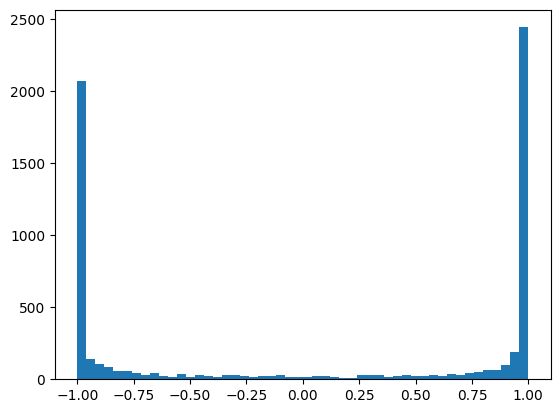

In [19]:
plt.hist(h.view(-1).tolist(), 50);

Tanh should squash values to fall between -1 and +1, but most of them being on the extremes is a problem

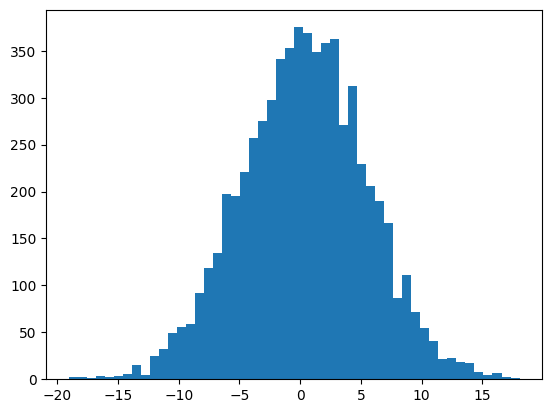

In [20]:
plt.hist(hpreact.view(-1).tolist(), 50);

We see here that the values are broad, and that's why everything is getting squashed to -1 and +1

This is a problem because of how back propagation works: values close to 1 for tanh mean that the backprop calculation is essentially zero and removes any change from the gradient

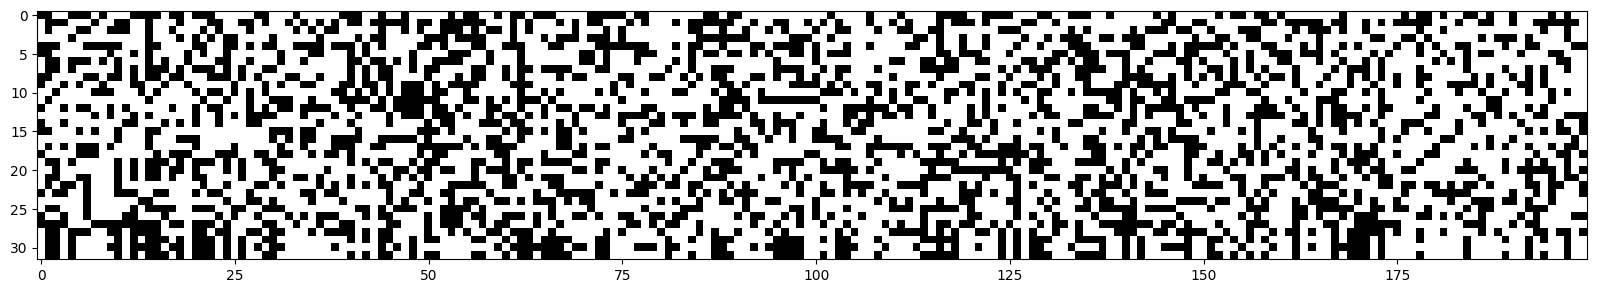

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

A lot of these squares are white, which means that tanh is very active and in the flat tails near +-1. If an entire column is white, that is a dead neuron (it will never learn). Since there aren't any dead neurons, some gradients do flow through.

Neurons can be dead by the initializations OR if the learning rate is too high and a neuron gets knocked out because they have too much of a gradient.

In this specific case, we can let the neural net optimize, even though this isn't optimal

Ideally, hpreact should be close to 0

In [22]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break
    

      0 /  200000: 3.3069


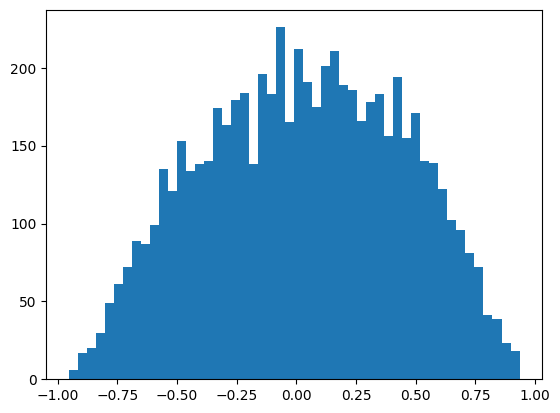

In [24]:
plt.hist(h.view(-1).tolist(), 50);

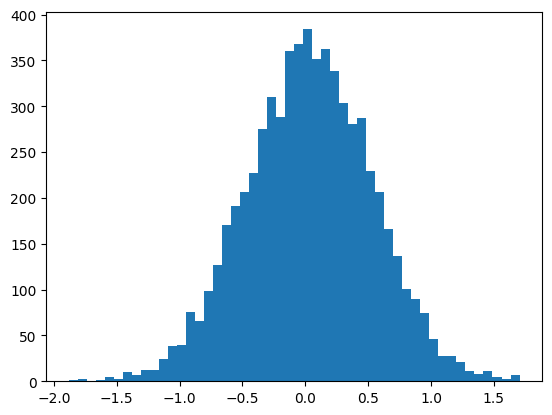

In [25]:
plt.hist(hpreact.view(-1).tolist(), 50);

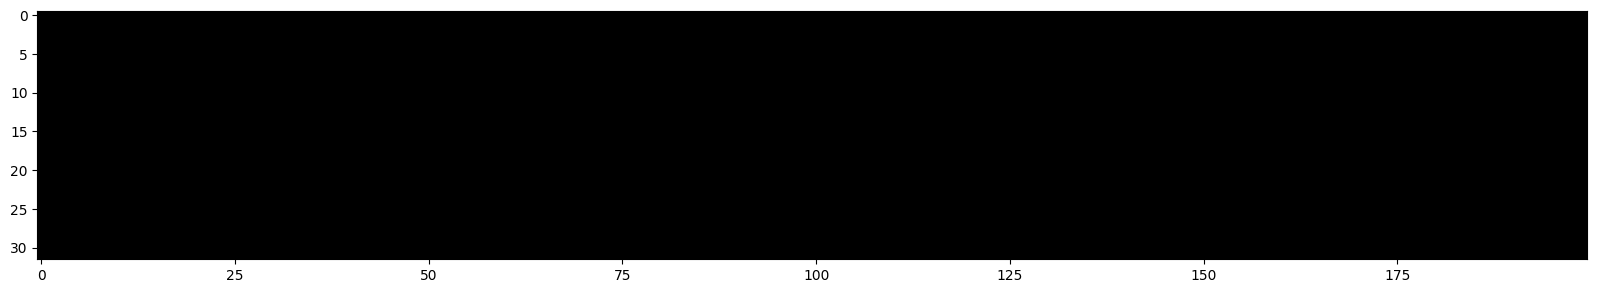

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [27]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break
    

      0 /  200000: 3.3135


  10000 /  200000: 2.1648
  20000 /  200000: 2.3061
  30000 /  200000: 2.4541
  40000 /  200000: 1.9787
  50000 /  200000: 2.2930
  60000 /  200000: 2.4232
  70000 /  200000: 2.0680
  80000 /  200000: 2.3095
  90000 /  200000: 2.1207
 100000 /  200000: 1.8269
 110000 /  200000: 2.2045
 120000 /  200000: 1.9797
 130000 /  200000: 2.3946
 140000 /  200000: 2.1000
 150000 /  200000: 2.1948
 160000 /  200000: 1.8619
 170000 /  200000: 1.7809
 180000 /  200000: 1.9673
 190000 /  200000: 1.8295


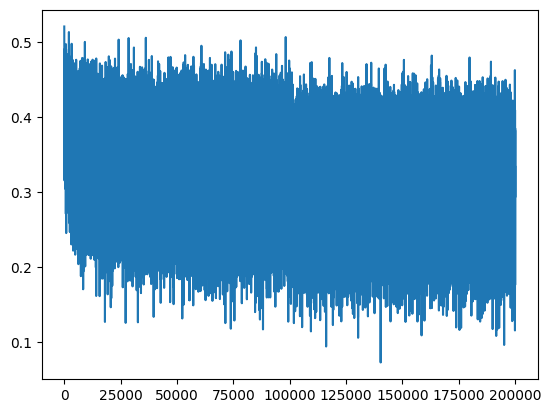

In [29]:
plt.plot(lossi);

In [30]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


How were the magic numbers used to scale down W1, b1, W2, and b2 determined?

tensor(-0.0115) tensor(0.9877)
tensor(0.0009) tensor(3.1078)


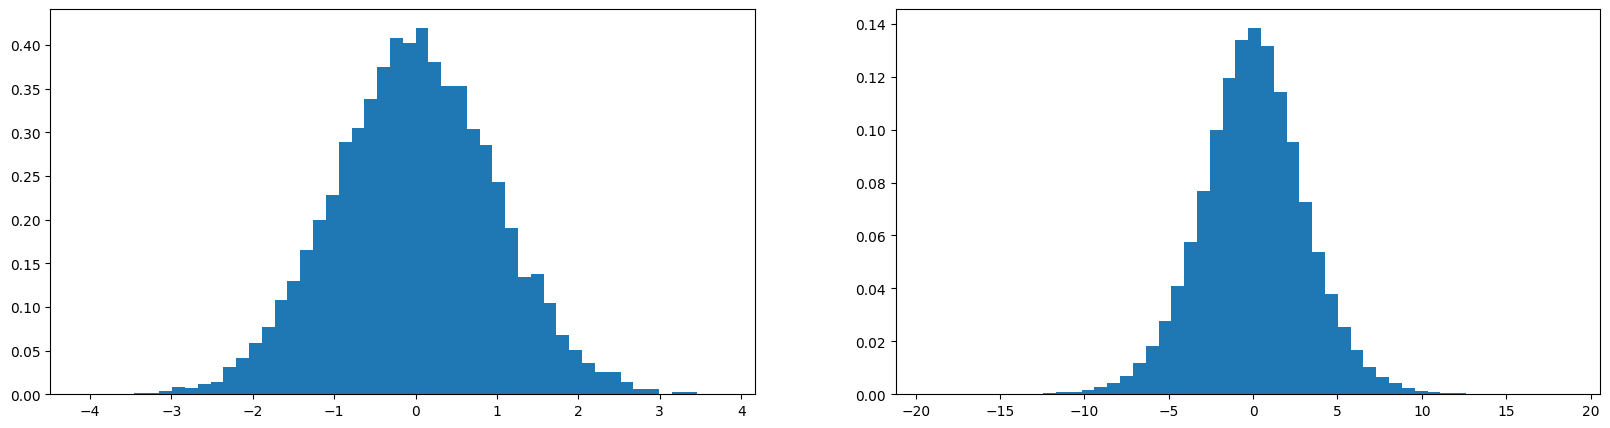

In [31]:
x = torch.randn(1000,10)
w = torch.randn(10, 200)
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

playing with the values/spread for w messes with y a lot and we want y to have a standard deviation ~1

Turns out, math has shown that we can divide by the square root of the "fan in" for w, which here is 10, for best control to keep y under control

There's a paper by Kaiming He referenced, and it turns out this is implemented in PyTorch and likely the most common way to initialize tensors now.

In addition, as time has gone on, there have been other improvements that put less importance on initializing perfectly (eg, residual connections, normalization layers, better optimizers).

In practice, Andrej initializes with the sqrt(fan in)

For us, that means

In [32]:
(5/3) / ((n_embd * block_size)**0.5)

0.3042903097250923

This becomes our coefficient for W1

In [33]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())   

      0 /  200000: 3.3179


  10000 /  200000: 2.1910
  20000 /  200000: 2.3270
  30000 /  200000: 2.5396
  40000 /  200000: 1.9468
  50000 /  200000: 2.3331
  60000 /  200000: 2.3852
  70000 /  200000: 2.1173
  80000 /  200000: 2.3159
  90000 /  200000: 2.2010
 100000 /  200000: 1.8591
 110000 /  200000: 2.0881
 120000 /  200000: 1.9389
 130000 /  200000: 2.3913
 140000 /  200000: 2.0949
 150000 /  200000: 2.1458
 160000 /  200000: 1.7824
 170000 /  200000: 1.7249
 180000 /  200000: 1.9751
 190000 /  200000: 1.8614


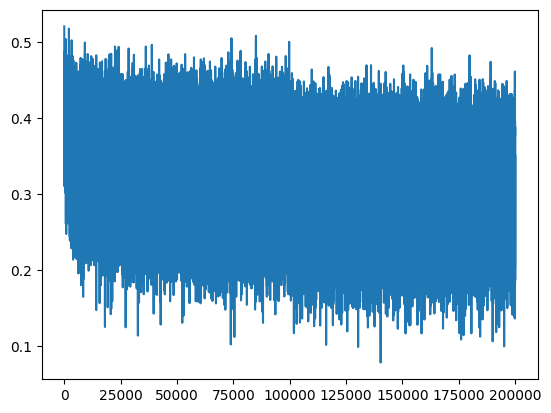

In [35]:
plt.plot(lossi);

In [36]:
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


## Demoing BatchNormalization

Make the pre-activations roughly unit Gaussian, because there's actually technically wrong with doing that

In [37]:
hpreact.shape

torch.Size([32, 200])

In [38]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [39]:
loss = -probs[torch.arange(32), Ytr].log().mean()
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # hidden layer pre-activation
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1) # (32, 100)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

NameError: name 'Y' is not defined

Initializing to unit Gaussian is fine, but should not force that to happen every epoch

In [40]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3147
  10000 /  200000: 2.1984
  20000 /  200000: 2.3375
  30000 /  200000: 2.4359
  40000 /  200000: 2.0119
  50000 /  200000: 2.2595
  60000 /  200000: 2.4775
  70000 /  200000: 2.1020
  80000 /  200000: 2.2788
  90000 /  200000: 2.1862
 100000 /  200000: 1.9474
 110000 /  200000: 2.3010
 120000 /  200000: 1.9837
 130000 /  200000: 2.4523
 140000 /  200000: 2.3839
 150000 /  200000: 2.1987
 160000 /  200000: 1.9733
 170000 /  200000: 1.8668
 180000 /  200000: 1.9973
 190000 /  200000: 1.8347


In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


Typically, we add a batch normalization layer after a linear layer

However, there is a cost associated with making this layer; h and logits end up becoming dependent on other inputs in both forward and backward pass. Accidentally causes regularization

With Batch Normalization, inference becomes harder. Easiest way is to do the following

In [43]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation


    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3147


  10000 /  200000: 2.1984
  20000 /  200000: 2.3375
  30000 /  200000: 2.4359
  40000 /  200000: 2.0119
  50000 /  200000: 2.2595
  60000 /  200000: 2.4775
  70000 /  200000: 2.1020
  80000 /  200000: 2.2788
  90000 /  200000: 2.1862
 100000 /  200000: 1.9474
 110000 /  200000: 2.3010
 120000 /  200000: 1.9837
 130000 /  200000: 2.4523
 140000 /  200000: 2.3839
 150000 /  200000: 2.1987
 160000 /  200000: 1.9733
 170000 /  200000: 1.8668
 180000 /  200000: 1.9973
 190000 /  200000: 1.8347


In [45]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [46]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5731,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0112,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0389,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [47]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0698, -0.0781,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2400,  2.0104,  0.6695,  0.0768, -0.0851, -1.6768,  0.2963,
          2.2374, -0.0100, -0.6670,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # hidden layer pre-activation
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # hidden layer pre-activation


    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 2.2236
  10000 /  200000: 1.7011
  20000 /  200000: 2.5979
  30000 /  200000: 2.5349
  40000 /  200000: 2.2926
  50000 /  200000: 2.4474
  60000 /  200000: 2.2451
  70000 /  200000: 1.9564
  80000 /  200000: 2.3291
  90000 /  200000: 2.2640
 100000 /  200000: 1.8879
 110000 /  200000: 2.1015
 120000 /  200000: 1.9611
 130000 /  200000: 2.3923
 140000 /  200000: 1.9997
 150000 /  200000: 2.4829
 160000 /  200000: 2.1175
 170000 /  200000: 2.0989
 180000 /  200000: 1.9290
 190000 /  200000: 2.1549


When using Batch Normalization, layer by layer bias gets canceled out since BatchNorm has its own bias

In [50]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [51]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # linear layer
    hpreact = embcat @ W1 # hidden layer pre-activation
    
    # BatchNorm layer
    # this layer usually comes after any layer with multiplications
    # like a linear layer or a convolutional layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias 
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3239
  10000 /  200000: 2.0322
  20000 /  200000: 2.5675
  30000 /  200000: 2.0125
  40000 /  200000: 2.2446
  50000 /  200000: 1.8897
  60000 /  200000: 2.0785
  70000 /  200000: 2.3681
  80000 /  200000: 2.2918
  90000 /  200000: 2.0238
 100000 /  200000: 2.3673
 110000 /  200000: 2.3132
 120000 /  200000: 1.6414
 130000 /  200000: 1.9311
 140000 /  200000: 2.2231
 150000 /  200000: 2.0027
 160000 /  200000: 2.0997
 170000 /  200000: 2.4949
 180000 /  200000: 2.0199
 190000 /  200000: 2.1707


Going over ResNet: A residual neural net for images

For very deep networks, ReLu tends to be better than tanh

ResNet uses BottleNeck blocks, which are actually very similar to what we have been doing here

When using BatchNorm in PyTorch, there's a parameter called 'momentum' that defaults to 0.1. Having such a high number is fine for large batches, but for our case with batch sizes of 32, it's too high. It makes bmeani unstable, so that's why we dampen it down

Important parts of this lecture:
1. Understanding activations, gradients, and their statistics in neural networks
   1. This allows fixing hockey stick losses from too-confident predictions

Try to avoid BatchNormalization; it was likely the first normalization layer, but introduces problems because it couples examples in a forward pass
    Recommends Group or Layer Normalization

Summary and Torch-ifying code

In [61]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)                 # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)    # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))  # normalizing to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [62]:
n_embd = 10    # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)   # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

In [63]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [65]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0 /  200000: 3.2989


layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.03%
layer 3 (      Tanh): mean +0.00, std 0.68, saturated: 8.38%
layer 5 (      Tanh): mean -0.00, std 0.67, saturated: 7.41%
layer 7 (      Tanh): mean -0.03, std 0.66, saturated: 5.81%
layer 9 (      Tanh): mean -0.03, std 0.66, saturated: 6.59%


Text(0.5, 1.0, 'activation distribution')

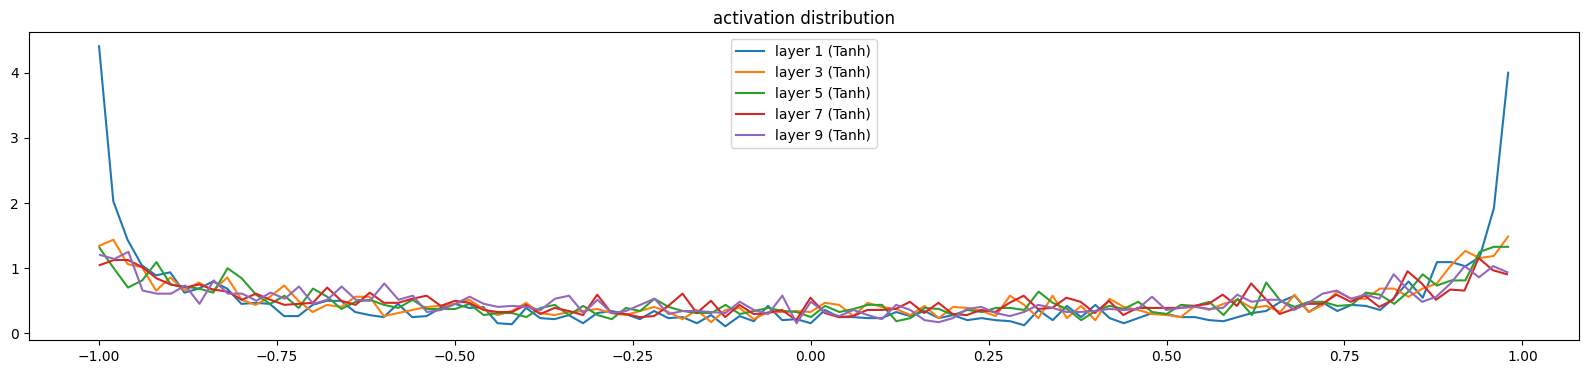

In [72]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

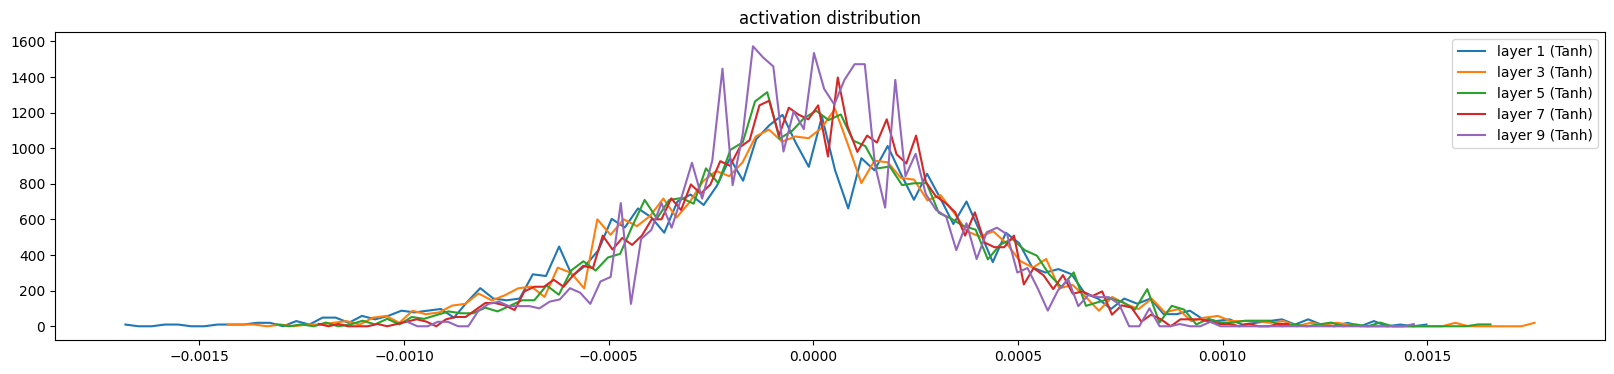

In [73]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000056 | std 1.562453e-03 | grad:data ratio 1.561323e-03
weight  (30, 100) | mean -0.000024 | std 1.399530e-03 | grad:data ratio 4.487636e-03
weight (100, 100) | mean +0.000003 | std 1.251627e-03 | grad:data ratio 7.534427e-03
weight (100, 100) | mean -0.000003 | std 1.056769e-03 | grad:data ratio 6.294623e-03
weight (100, 100) | mean +0.000006 | std 9.340962e-04 | grad:data ratio 5.587305e-03
weight (100, 100) | mean -0.000004 | std 8.971729e-04 | grad:data ratio 5.361252e-03
weight  (100, 27) | mean +0.000000 | std 2.598269e-02 | grad:data ratio 2.546178e+00


Text(0.5, 1.0, 'weights gradient distibution')

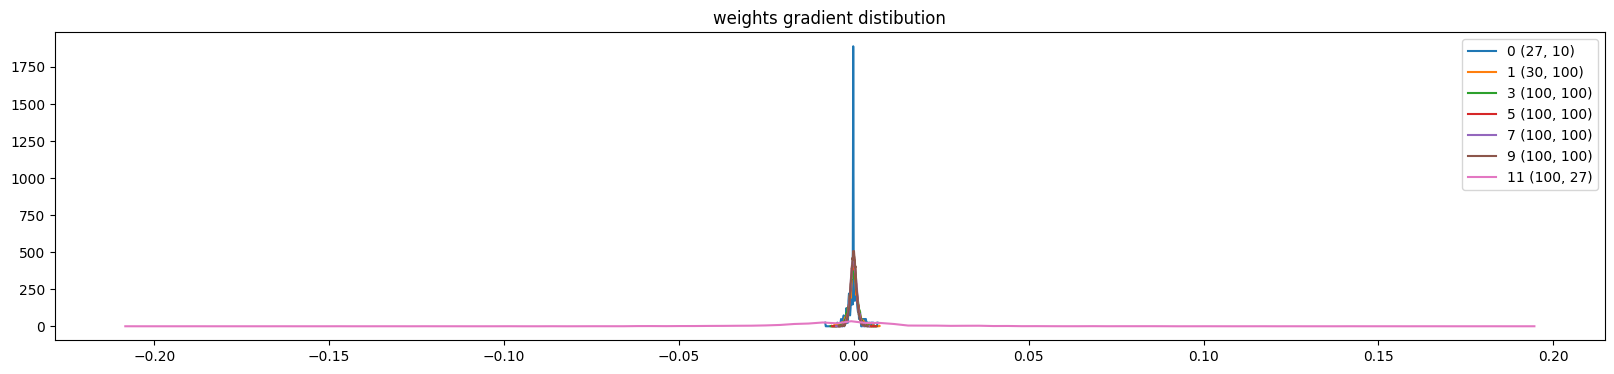

In [80]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for forr, p in enumerate(parameters): # note: exclude output layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std() ) )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f'{forr} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distibution')

In [82]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0 /  200000: 2.3295


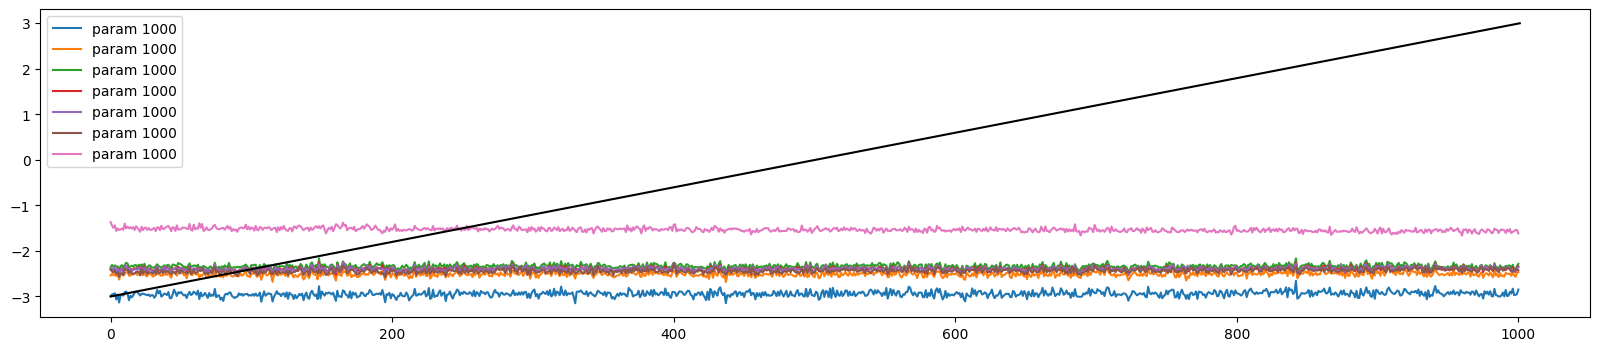

In [86]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for forr, p in enumerate(parameters): # note: exclude output layer
    if p.ndim == 2:
        plt.plot([ud[j][forr] for j in range(len(ud))]);
        legends.append('param %d' % forr)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3
plt.legend(legends);
# plt.title('weights gradient distibution')

In [88]:
n_embd = 10    # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)   # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [89]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0 /  200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

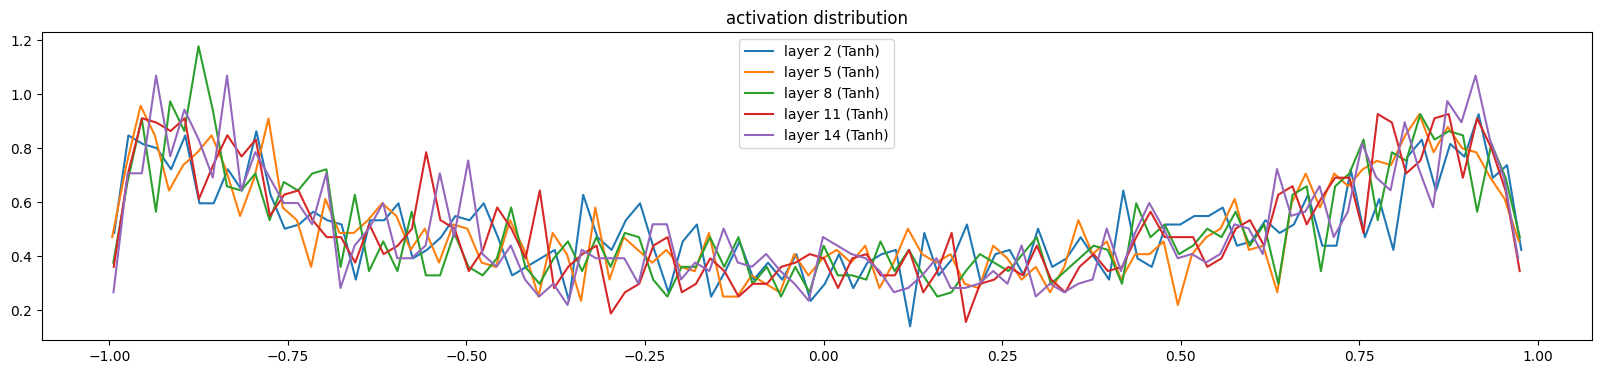

In [90]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

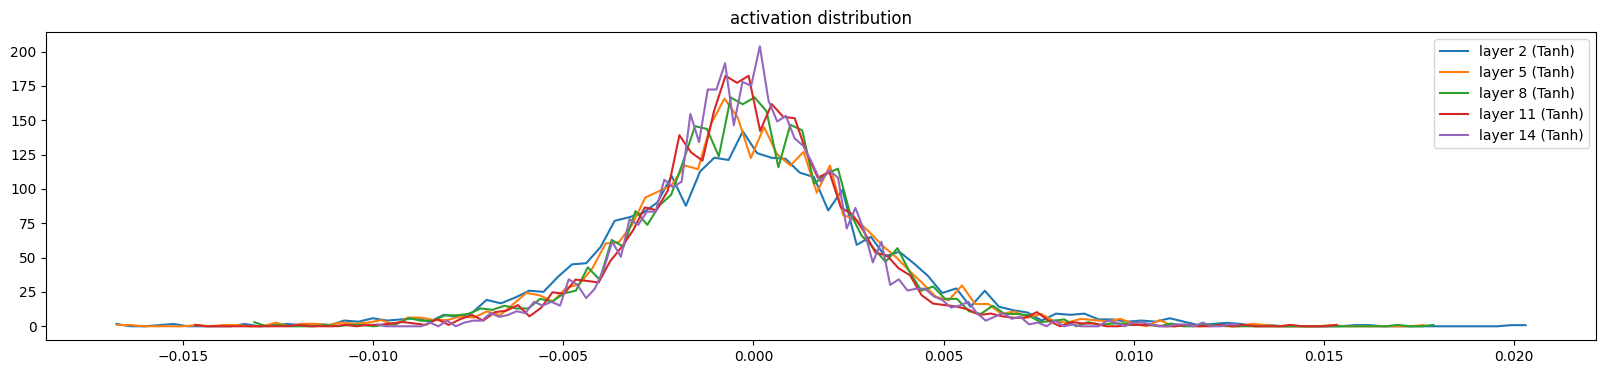

In [91]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean -0.000000 | std 1.019887e-02 | grad:data ratio 1.018847e-02
weight  (30, 100) | mean +0.000092 | std 8.238433e-03 | grad:data ratio 2.635840e-02
weight (100, 100) | mean +0.000031 | std 7.318115e-03 | grad:data ratio 4.377146e-02
weight (100, 100) | mean -0.000019 | std 6.662024e-03 | grad:data ratio 3.949896e-02
weight (100, 100) | mean -0.000019 | std 5.821517e-03 | grad:data ratio 3.468161e-02
weight (100, 100) | mean +0.000053 | std 5.445297e-03 | grad:data ratio 3.243368e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281266e-02


Text(0.5, 1.0, 'weights gradient distibution')

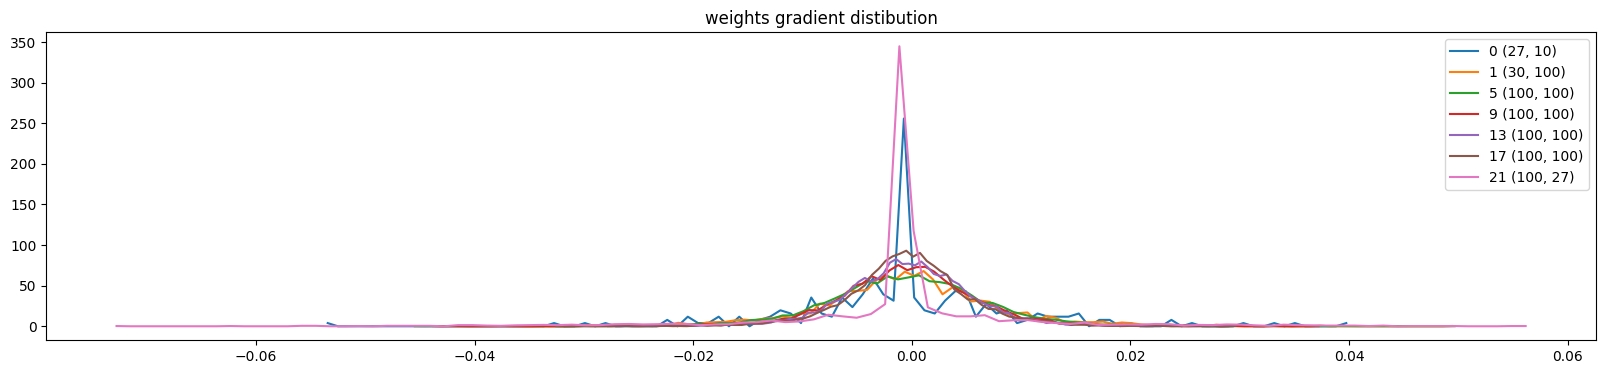

In [92]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for forr, p in enumerate(parameters): # note: exclude output layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std() ) )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f'{forr} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distibution')

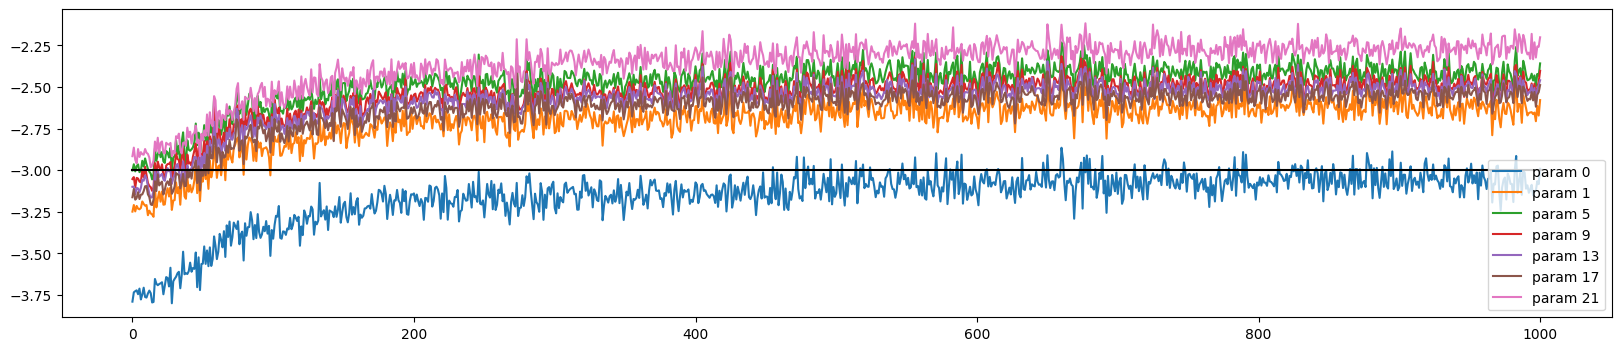

In [95]:
# visualize histograms 
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []

for forr, p in enumerate(parameters): # note: exclude output layer
    if p.ndim == 2:
        plt.plot([ud[j][forr] for j in range(len(ud))]);
        legends.append('param %d' % forr)
plt.plot([0, len(ud)], [-3, -3], 'k'); # these ratios should be ~1e-3
plt.legend(legends);
# plt.title('weights gradient distibution')

## Summary of Lecture

1. Introduce Batch Normalization
   1. Helped stabilize deep neural nets
2. PyTorchify some of our code 
   1. Classes
3. Introduce diagnostics for how to evaluate if your neural net is in a good state dynamically
   1. Histograms and statistics on gradients/updates
   2. -3 on log scale is a good rough heuristic